## Cleaning Data
The file '1mio-raw.csv' is the raw dataset to be cleaned.
The file '1mio-clean.csv' is the cleaned dataset (though still containing duplicate rows).
The function "clean_content" is defined for cleaning the article contents, meaning purely the text data. 
This function is applied in chunks along the cleaning of certain parts of the meta-data.

In [1]:
#import modules
import pandas as pd
import numpy as np
import re

In [2]:
in_filepath = '~/Documents/DataScience Notebooks/csv/1mio-raw.csv'
out_filepath = '~/Documents/DataScience Notebooks/csv/1mio-clean.csv'

In [3]:
# function to clean content field
def clean_content(text):

    # regular expression for dates
    def re_date():
        re_numdate = r'(?:\d{1,4}(?:\/\d{1,2}\/|-\d{1,2}-)\d{1,4})'
        re_day = r'(?:\d{1,2}(?:th|st|nd|rd|\.)?)'
        re_month = r'(?:jan(?:uary|\.)?|feb(?:ruary|\.)?|mar(?:ch|\.)?|apr(?:il|\.)?|may\.?|jun(?:e|\.)?' \
                   r'|jul(?:y|\.)?|aug(?:ust|\.)?|sept?(?:ember|\.)?|oct(?:ober|\.)?|nov(?:ember|\.)?' \
                   r'|dec(?:ember|\.)?)'
        re_year = r'(?:[, ]*\d{4})?'
        reg = r'(' + re_numdate + \
              r'|(?:' + re_month + r'[, ]*' + re_day + re_year + r')' \
              r'|(?:(?:the)? ?' + re_day + r' (?:of)? ?' + re_month + re_year + r'))'   
        return re.compile(reg)
    
    if pd.notnull(text):
        re_whitespace = re.compile(r"(\s+)")
        re_urls = re.compile(r"(?<=\s)((?:https?://)?\w+(?:\.?\w)*\.(?:com|org|net|dk)(?:\/[\w/?.#=\-+%]*)?)")
        re_email = re.compile(r"(?<=\s)(\w(?:\.?[\w+\-])*@\w(?:[.\-]?\w)*)")
        re_date = re_date()
        re_num = re.compile(r"(\d+(?:,\d{3})*(?:\.\d+)?)")

        text = re_whitespace.sub(' ',text)
        text = text.lower()
        text = re_urls.sub('<URL>',text)
        text = re_email.sub('<EMAIL>',text)
        text = re_date.sub('<DATE>',text)
        text = re_num.sub('<NUM>',text)

        return text
    else:
        return None
    
# string to list
def makelist(x): return x.lower().split(', ') if pd.notnull(x) else None

# lower text
def low(x): return x.lower() if pd.notnull(x) else None

In [4]:
# load data
reader = pd.read_csv(in_filepath, dtype={'id':'str'}, chunksize=10000)
b = True

# clean data
for df in reader:
    #filter out rows where id is null or not a digit (int)
    df = df.drop(df.loc[df['id'].map(lambda x: not str.isdigit(x) if pd.notnull(x) else True)].index)
    
    # set invalid values for authors to None
    invalid_name = 'Backgroundurl Avatar_Large, Nickname, Joined, Created_At, Story Count, N_Stories, Comment Count, N_Comments, Popular Tags, Showtags Popular_Tags'
    df.loc[(df['authors'] == invalid_name) | (df['authors'] == 'Posted On'), ['authors']] = None

    # set invalid values for tags to None
    df.loc[(df['tags'] == 'View Tags') | (df['tags'] == 'Next') | (df['tags'] == '(Load)'), ['tags']] = None 

    # lower title, meta_description, meta_keywords
    df['title'] = df['title'].apply(low)
    df['meta_description'] = df['meta_description'].apply(low)
    df['meta_keywords'] = df['meta_keywords'].apply(low)
    
    # clean null-values in meta_keywords
    df.loc[df['meta_keywords'] == "['']", ['meta_keywords']] = None 
    
    # convert strings to lists
    df['authors'] = df['authors'].apply(makelist)
    df['tags'] = df['tags'].apply(makelist)
    
    # clean content
    df['content'] = df['content'].apply(clean_content)
    
    # clean types
    df['type'] = df['type'].apply(lambda x: None if x=='unknown' or pd.isnull(x) or x=='' else x)
    
    if b:
        # write header
        df.to_csv(out_filepath, index=False, mode='w')
        b = False
    else:
        df.to_csv(out_filepath, index=False, header=False, mode='a')

## Visualizing duplicate rows
The cleaned dataset '1mio-clean.csv' contains duplicate rows that should be removed before the dataset can be used to train a model.

In [5]:
#import modules
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#load clean data (column 3: type, column 5: content)
df = pd.read_csv(out_filepath,usecols=[3,5]) 
#drop null-types
df = df.dropna()
#map to binary classes
df['b_type'] = df['type'].apply(lambda x: 'FAKE' if x in ['fake','satire','bias','conspiracy','junksci'] else 'REAL')
#new df
df2 = df.drop_duplicates()

In [7]:
#initial df
df

,type,content,b_type
0,rumor,"life is an illusion, at least on a quantum lev...",REAL
1,hate,"unfortunately, he hasn’t yet attacked her for ...",REAL
2,hate,the los angeles police department has been den...,REAL
3,hate,the white house has decided to quietly withdra...,REAL
4,hate,“the time has come to cut off the tongues of t...,REAL
...,...,...,...
999929,unreliable,tor tor is an encrypted anonymising network th...,REAL
999930,unreliable,tor tor is an encrypted anonymising network th...,REAL
999931,unreliable,tor tor is an encrypted anonymising network th...,REAL
999932,unreliable,tor tor is an encrypted anonymising network th...,REAL


In [8]:
#demonstrate that content is the same
df.iloc[-1]['content'] == df.iloc[-2]['content']

True

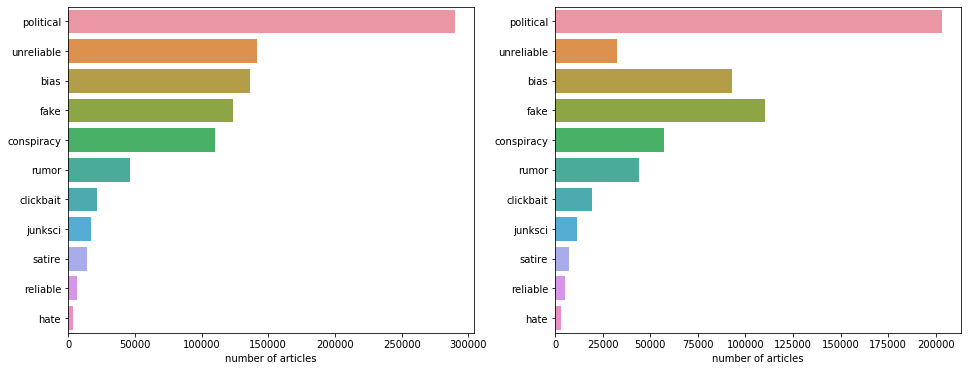

In [9]:
#histogram of dataset by type before and after duplicate removal
fig, axes = plt.subplots(ncols=2, figsize=(16,6))
x = df.type.value_counts(sort=True)
x2 = df2.type.value_counts()
x_dict = {e:i for i,e in enumerate(x)}
x2_dict = {e:i for i,e in enumerate(x2)}
x2 = sorted(x2, key=lambda z: x[x2.index[x2_dict[z]]], reverse=True)
sns.barplot(x, x.index, ax=axes[0])
sns.barplot(x2, x.index, ax=axes[1])
axes[0].set_xlabel('number of articles')
axes[1].set_xlabel('number of articles')
pass

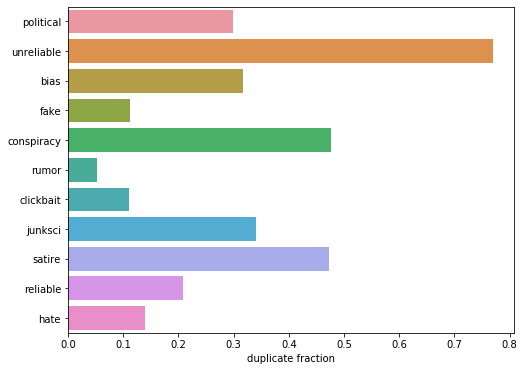

In [10]:
#demonstrating how large a fraction is removed (by type)
x3 = x-x2
plt.figure(figsize=(8,6))
sns.barplot(np.divide(x3,x), x.index)
plt.gca().set_xlabel('duplicate fraction')
pass

In [11]:
#overall percentage dropped
print(f"duplicates: {(len(df)-len(df2))/len(df)*100} %")

duplicates: 35.61289317525323 %


In [12]:
#tables
print('With duplicates:')
print(pd.DataFrame({'label':x.index,'quantity':x.values,'percent':x.values/sum(x)*100}))
print('\nWithout duplicates:')
print(pd.DataFrame({'label':x.index,'quantity':x2,'percent':np.array(x2)/sum(x2)*100}))
print('\nDifference:')
print(pd.DataFrame({'label':x.index,'quantity':x3.values,'percent':np.divide(x3,x).values*100}))

With duplicates:
         label  quantity    percent
0    political    289666  31.778313
1   unreliable    141614  15.536011
2         bias    136381  14.961915
3         fake    123929  13.595847
4   conspiracy    109793  12.045032
5        rumor     46524   5.103997
6    clickbait     21723   2.383160
7      junksci     17408   1.909775
8       satire     14263   1.564747
9     reliable      6601   0.724174
10        hate      3619   0.397029

Without duplicates:
         label  quantity    percent
0    political    203020  34.591806
1   unreliable     32512   5.539596
2         bias     93109  15.864488
3         fake    110046  18.750319
4   conspiracy     57463   9.790902
5        rumor     44097   7.513520
6    clickbait     19328   3.293224
7      junksci     11478   1.955693
8       satire      7514   1.280282
9     reliable      5222   0.889757
10        hate      3113   0.530412

Difference:
         label  quantity    percent
0    political     86646  29.912382
1   unreliabl

## Detecting Russian articles

In [13]:
#finding Russian articles
df_r = df[df['content'].str.match('[а-яА-Я]')].copy()
df_r

,type,content,b_type
111436,bias,"александра зиновьева, философа, социолога и ло...",FAKE
111440,bias,автор статьи - датская журналистка и теолог ни...,FAKE
111449,bias,президент чехии обрушился с градом критики на ...,FAKE
111678,bias,"глобальный полицейский заблуждается, если дума...",FAKE
111679,bias,на этой неделе несколько высокопоставленных ва...,FAKE
...,...,...,...
919341,bias,россия и эстония взяли курс на улучшение отнош...,FAKE
919445,bias,крупная кража на криптовалютном рынке: все дел...,FAKE
919446,bias,украина опоздала с крымом украина могла бы пом...,FAKE
919463,bias,вчера в <NUM>:<NUM> крупнейшая площадка торгов...,FAKE


In [14]:
#counting character occurences
df_r['count'] = df_r['content'].apply(lambda x: len(re.findall(r"([а-яА-Я])",x)))

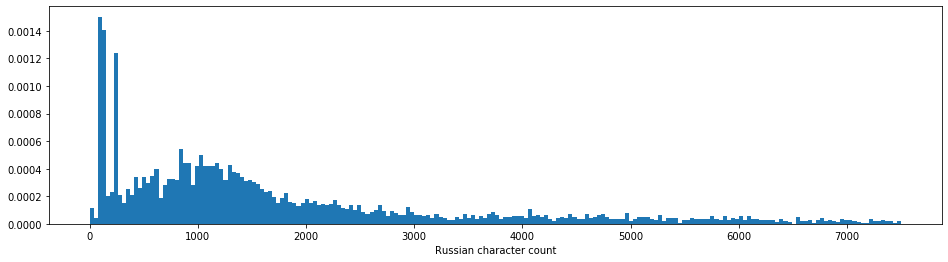

In [15]:
fig, axes = plt.subplots(figsize=(16,4))   

plt.xlabel('Russian character count')

n, bins, patches = plt.hist(df_r['count'], 200,  
                            density = 1, range =[0,7500])


Most of the articles detected contain a fairly large amount of non-English characters. They can be removed with reduced fear of loss of relevant data.

## Detecting Greek articles 

In [16]:
#finding Russian articles
df_g = df[df['content'].str.match('[Α-Ωα-ωίϊΐόάέύϋΰήώ]')].copy()
df_g

,type,content,b_type
333608,bias,ο επίτροπος για την ψηφιακή οικονομία και την ...,FAKE
333880,bias,η εε απέχει παρασάγγας από τον στόχο της να με...,FAKE
334336,bias,ενώ η αυστρία απειλεί με βέτο στο ψήφισμα των ...,FAKE
334338,bias,οι ψηφοφόροι των χωρών-μελών της ευρωπαϊκής έν...,FAKE
334351,bias,"αλβανια, η κολομβια της ευρωπης η αλβανία έχει...",FAKE
...,...,...,...
470593,bias,οι ρουμάνοι άρχισαν να ψηφίζουν σήμερα στις βο...,FAKE
470609,bias,"δεκάδες διανοούμενοι, πολιτικοί, δημοσιογράφοι...",FAKE
470610,bias,σφοδρή επίθεση στην κυβέρνηση εξαπέλυσε η επικ...,FAKE
687116,fake,μan gets electrocuted as he tries to steal ele...,FAKE


In [17]:
#counting character occurences
df_g['count'] = df_g['content'].apply(lambda x: len(re.findall(r"([Α-Ωα-ωίϊΐόάέύϋΰήώ])",x)))

In [18]:
#controlling overlap beetween Russian and Greek articles
rus = set(df_r['content'])
greek = set(df_g['content'])

print(f'Articles in common: {len(rus.intersection(greek))}')

Articles in common: 0


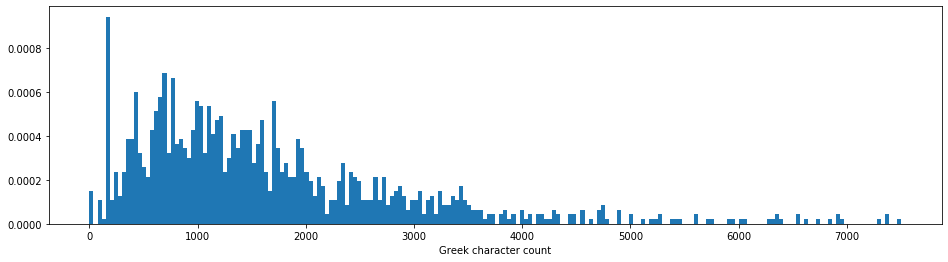

In [19]:
fig, axes = plt.subplots(figsize=(16,4))   

plt.xlabel('Greek character count')

n, bins, patches = plt.hist(df_g['count'], 200,  
                            density = 1, range =[0,7500])

Most of the articles detected contain a fairly large amount of non-English characters. They can be removed with reduced fear of loss of relevant data.